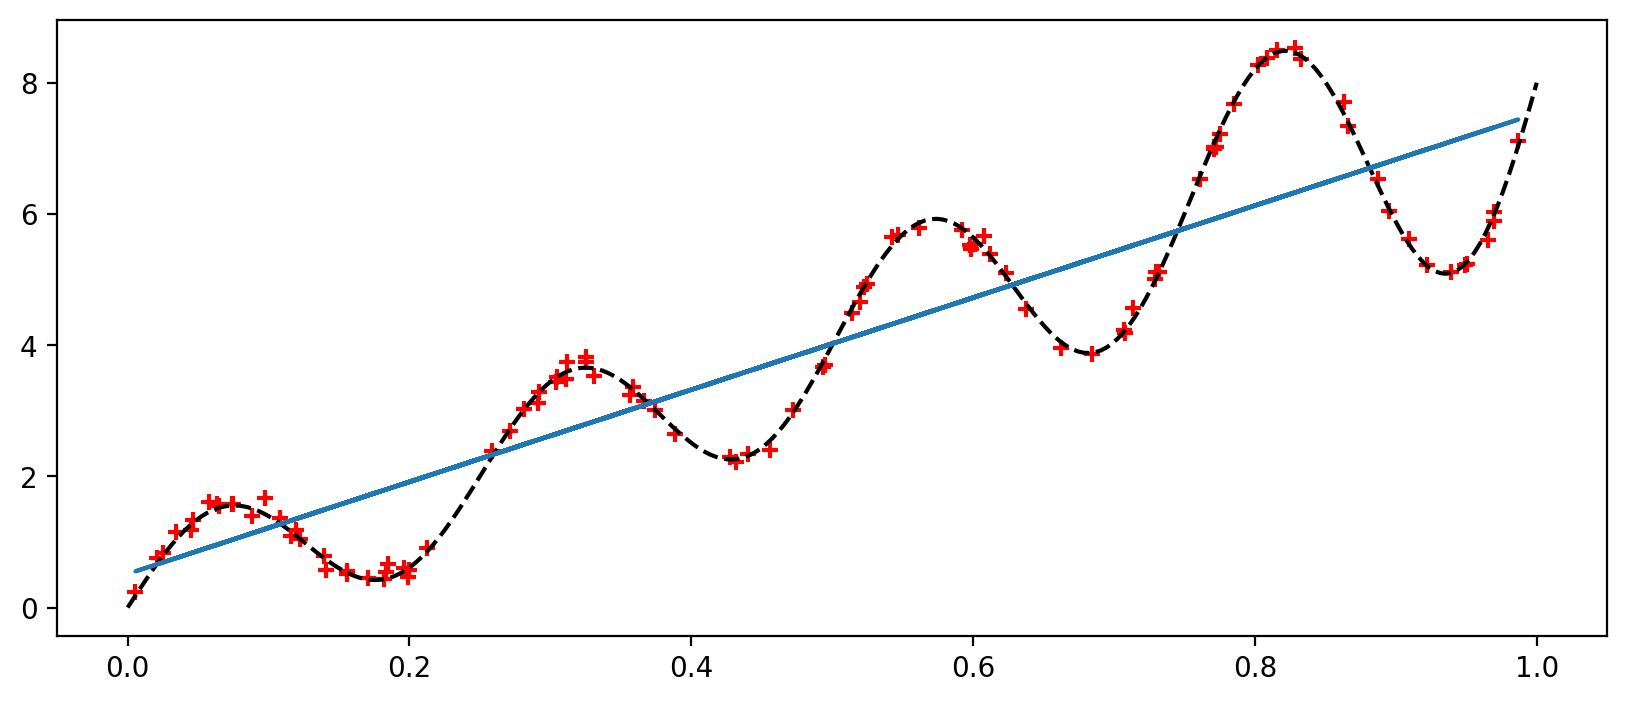

In [1]:
import sys
sys.path.append("..")   # add parent folder (project/) to Python path

from gplib.gp import *   # now absolute import works
import numpy as np 
import math 
import matplotlib.pyplot as plt 

np.random.seed(42)
N_points = 100
x = np.random.uniform(0,1,N_points).reshape(-1,1)
func = lambda x: np.exp(x**2)*np.sin(8*math.pi*x) + 8*x
y = ( func(x) + np.random.randn(x.shape[0], x.shape[1])*1e-1).ravel()
xtest = np.linspace(0,1,250).reshape(-1,1)
ytest = func(xtest)

plt.figure(figsize=(10,4), dpi=200)
plt.scatter(x,y, marker = '+', color = 'red')
plt.plot(xtest, ytest, linestyle = 'dashed', color = 'black', label = 'target')

Phi = jnp.hstack((jnp.ones((x.shape[0],1)), x))
beta = jnp.linalg.solve(Phi.T @ Phi + 1e-8 * jnp.eye(Phi.shape[1]), Phi.T @ y)
plt.plot(x, Phi @ beta, label = "Least squares approximation")

In [90]:
model = SVGP(x, y, RBF, Linear, M = 20, noise_var = 1e-6, kernel_params = jnp.ones(2), epsilon = 1e-12, max_cond = 1e5, calibrate=True)
optimizer = Momentum(model, lambda model, p: svgp_neg_mll(model, p, N_mc = 25, seed = 42), beta = 0.0, constraints = model.constraints)
optimizer.latin_hypercube_init('k_param', 100, min=-50, max = 50)

Calibrated white noise variance: 1.1563e-03
Best Objective Value: 2.2154e+04


In [98]:
optimizer.beta = 0.9
optimizer.run(1e-8, 500, ['k_param', 'q_L', 'q_mu', 'Z'])

100%|██████████| 500/500 [00:17<00:00, 28.13it/s, Loss: 4.8283e+03]


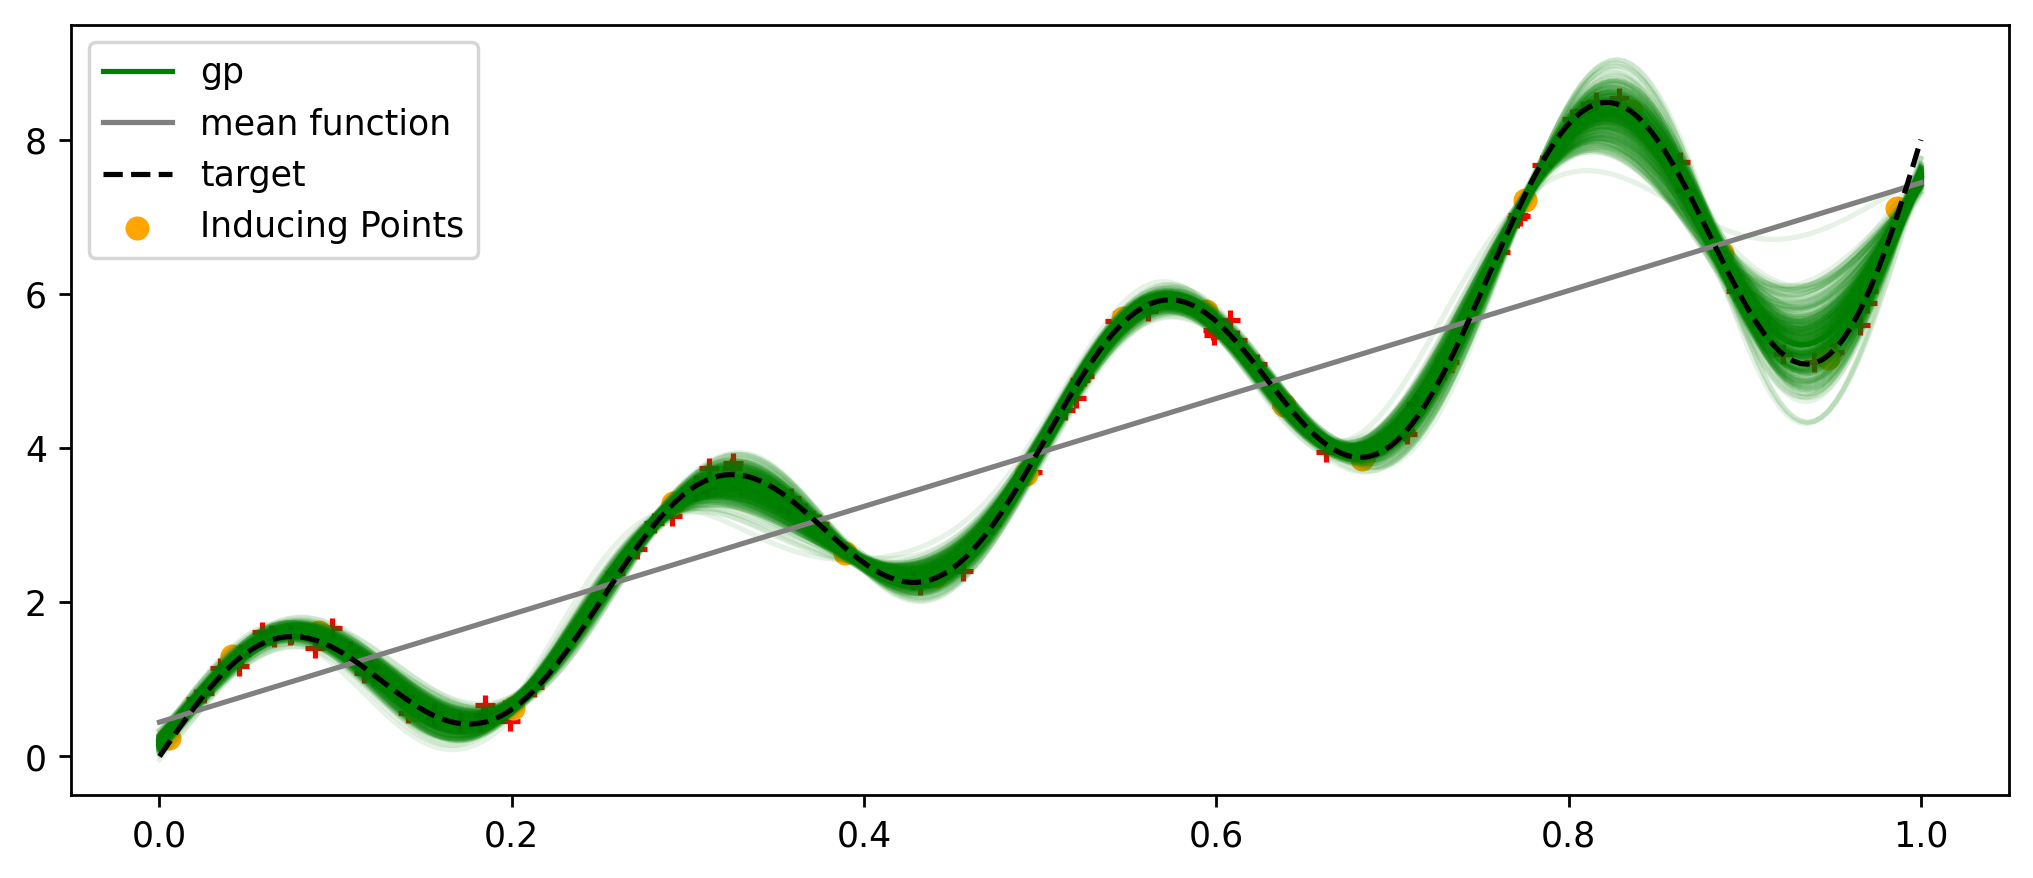

In [99]:
full_samp = model.predict(xtest, full_samp = True, N_mc = int(1e6), seed = 41)
plt.figure(figsize=(10,4), dpi = 250)
plt.scatter(x,y, marker = '+', color = 'red')
plt.plot(xtest, full_samp.mean(axis=0), color = 'green', label = 'gp')
for i in range(full_samp.shape[1]):
    plt.plot(xtest, full_samp[i,:], color = 'green', alpha = 0.1)
plt.plot(xtest, model.mean.eval(xtest, model.p['m_param']), color = 'gray', label = 'mean function')
plt.plot(xtest, ytest, linestyle = 'dashed', color = 'black', label = 'target')
plt.scatter(model.p['Z'].ravel(), model.p['q_mu'] + model.mean.eval(model.p['Z'], model.p['m_param']), s = 35, color = 'orange', label = "Inducing Points")
plt.legend()